# Sentiment Analysis

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import gensim.downloader as api
from sklearn.model_selection import train_test_split

## Load Datasets

In [ ]:
test_df = pd.read_csv('test_data.csv')
train_df = pd.read_csv('train_data.csv')
title_brand_df = pd.read_csv('title_brand.csv')

In [3]:
test_df.head()

,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,NaN,True,2018-06-04,A20GGWE66JW9X2,B006Z394GM,{'Color:': ' FPS01-C'},Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...,1528070400
1,NaN,True,2018-02-18,ARYJWXHEYHG9M,B005BE058W,"{'Size:': ' 1000W', 'Style:': ' G2'}",Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR,1518912000
2,NaN,True,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,NaN,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular,1516406400
3,NaN,True,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,NaN,Jeremy Bray,I purchased this 4 year protection plan for a ...,DO NOT BUY!!!,1529884800
4,3.0,True,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,NaN,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy,1471392000


In [4]:
train_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [5]:
title_brand_df.head()

,asin,title,brand
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision
1,0043396828,"Books ""Handbook of Astronomical Image Processi...",33 Books Co.
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page
3,0060219602,Hurray for Hattie Rabbit: Story and pictures (...,Visit Amazon's Dick Gackenbach Page
4,0060786817,sex.lies.murder.fame.: A Novel,Visit Amazon's Lolita Files Page


# Exploratory Data Analysis

## 1. Distribution of Overall Ratings

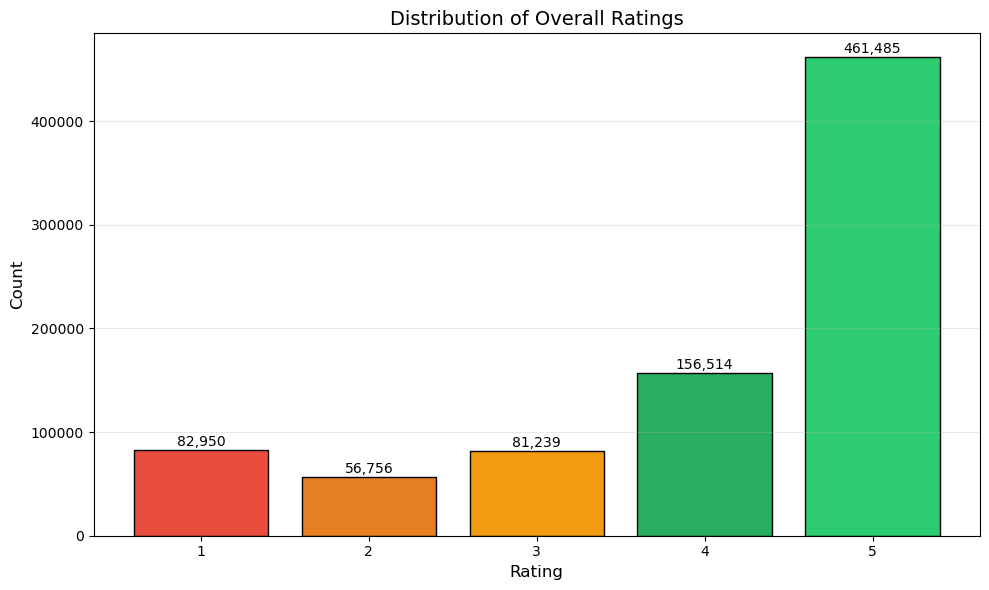

Percentage Distribution:

overall
1     9.887430
2     6.765171
3     9.683483
4    18.656072
5    55.007843
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(10, 6))
overall_counts = train_df['overall'].value_counts().sort_index()
colors = ['#e74c3c', '#e67e22', '#f39c12', '#27ae60', '#2ecc71']
bars = plt.bar(overall_counts.index, overall_counts.values, color=colors, edgecolor='black')

for bar, count in zip(bars, overall_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Overall Ratings', fontsize=14)
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

rating_dist = train_df['overall'].value_counts(normalize=True) * 100
print("Percentage Distribution:\n")
print(rating_dist.sort_index())

### Interpretation
The dataset is highly imbalanced. Instead of blindly resampling, we can use Class Weights for learning models. This penalizes mistakes on minority classes more heavily and is usually safer than oversampling.

## 2. Word Clouds (Positive / Neutral / Negative)

To better understand the textual patterns in the dataset, reviews are going to be grouped into three sentiment categories based on their rating:

- Positive: ratings 4 and 5
- Neutral: rating 3
- Negative: ratings 1 and 2

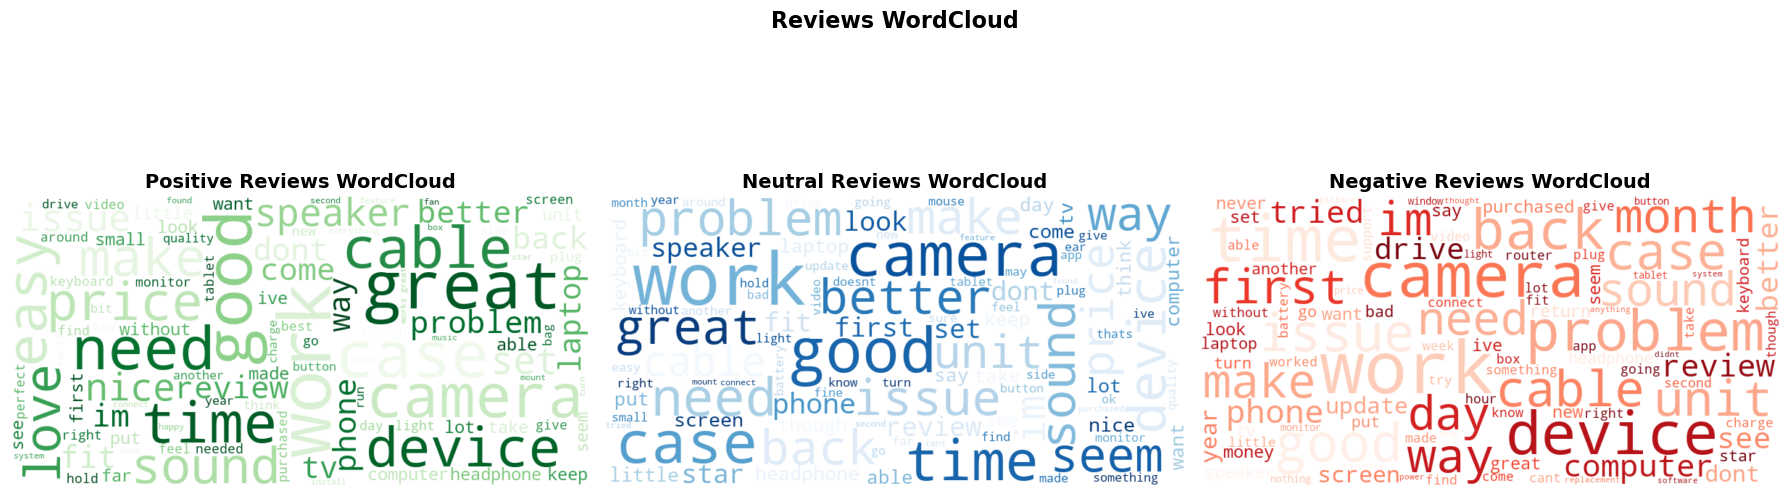

In [7]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# categorize sentiment (positive, neutral, negative)
def categorize_sentiment(overall):
    if overall >= 4:
        return 'positive'
    elif overall == 3:
        return 'neutral'
    else:
        return 'negative'

train_df['sentiment'] = train_df['overall'].apply(categorize_sentiment)

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords.words('english'))
custom_stopwords.update(['one', 'two', 'would', 'could', 'also', 'get', 'got',
                          'use', 'used', 'using', 'thing', 'things', 'really',
                          'even', 'much', 'well', 'still', 'just', 'like',
                          'amazon', 'product', 'item', 'buy', 'bought', 'purchase',
                          'ordered', 'order', 'received', 'came', 'arrived'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# wordcloud + plot
sentiments = ['positive', 'neutral', 'negative']
colors = ['Greens', 'Blues', 'Reds']

for idx, (sentiment, colormap) in enumerate(zip(sentiments, colors)):
    texts = train_df[train_df['sentiment'] == sentiment]['reviewText'].dropna()

    sample_size = min(50000, len(texts))
    combined_text = ' '.join(texts.sample(sample_size, random_state=42).apply(clean_text))

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords,
        max_words=100,
        colormap=colormap,
        min_font_size=10,
        max_font_size=100
    ).generate(combined_text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f"{sentiment.capitalize()} Reviews WordCloud", fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Reviews WordCloud', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Common Words Between Positive and Negative Reviews

In [8]:
def get_top_words(texts, n=50):
    all_words = []
    for text in texts.dropna().sample(min(30000, len(texts)), random_state=42):
        cleaned = clean_text(text)
        words = [w for w in cleaned.split() if w not in custom_stopwords and len(w) > 2]
        all_words.extend(words)
    return Counter(all_words).most_common(n)

positive_words = set([w[0] for w in get_top_words(train_df[train_df['sentiment'] == 'positive']['reviewText'])])
negative_words = set([w[0] for w in get_top_words(train_df[train_df['sentiment'] == 'negative']['reviewText'])])
common_words = positive_words.intersection(negative_words)

print(f"{len(common_words)} Common Words")
print(list(common_words)[:20])

29 Common Words
['cable', 'way', 'usb', 'dont', 'better', 'good', 'phone', 'work', 'power', 'need', 'new', 'ive', 'drive', 'screen', 'quality', 'great', 'camera', 'case', 'right', 'works']


### Interpretation

The common words shared between positive and negative reviews typically include:

1. Product and brand names (e.g., cable, battery, phone, etc.)
2. General descriptive words (e.g., quality, price, time)
3. Performance-related words (e.g., work, works, working)

These words appear in both sentiment categories because their polarity depends on context:

- In positive reviews:  
  - "great quality"  
  - "works perfectly"

- In negative reviews:  
  - "poor quality"  
  - "doesn't work"

Therefore, context and surrounding words are more important than the individual word itself in determining sentiment.

## 3. Top 10 Reviewers by Total Helpful Votes

In [9]:
train_df["vote"] = pd.to_numeric(train_df["vote"], errors="coerce").fillna(0)

top_reviewers = (
    train_df
    .groupby(["reviewerID", "reviewerName"], as_index=False)["vote"]
    .sum()
    .sort_values("vote", ascending=False)
    .head(10)
)
top_reviewers = top_reviewers.rename(columns={
    "reviewerID": "Reviewer ID",
    "reviewerName": "Reviewer Name",
    "vote": "Total Helpful Votes"
})
top_reviewers.index = range(1, len(top_reviewers) + 1)

print("\nTop 10 Reviewers by Total Helpful Votes\n")
display(top_reviewers)


Top 10 Reviewers by Total Helpful Votes



,Reviewer ID,Reviewer Name,Total Helpful Votes
1,A25GROL6KJV3QG,Benson Leung,4572.0
2,A2IK776FY6MEMG,Obi Wan,1608.0
3,A1A39899KH5QCI,Chris Winter,1352.0
4,AMYCUX8EWEUVV,Mayra S.,1342.0
5,A9K7V1MKJ9BOJ,VermontGuy,1337.0
6,A1UQUDT2Q0YENM,Michael,1230.0
7,A3R1WFO4KIUQXZ,PhotoGraphics,1209.0
8,A2Z9APP5B09MFY,Nicholas,1188.0
9,AOEAD7DPLZE53,NLee the Engineer,1103.0
10,AZPCDY9OQ605E,David H,1045.0


## 4. Histogram of Review Length

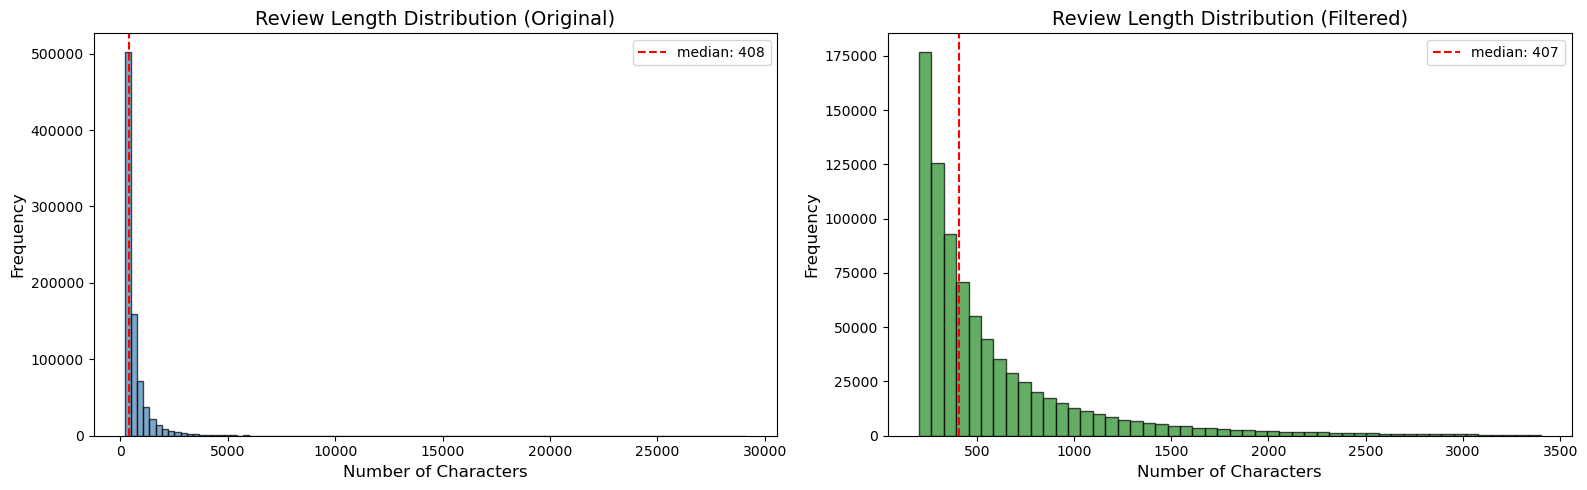

Descriptive Statistics of Review Text Length:
Minimum: 200
Maximum: 29,146
Mean: 624.69
Median: 408
Standard Deviation: 684.13

Percentiles:
  25th percentile: 277
  50th percentile: 408
  75th percentile: 697
  90th percentile: 1,217
  95th percentile: 1,733
  99th percentile: 3,399


In [10]:
train_df['text_length'] = train_df['reviewText'].astype(str).apply(len)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# original histogram
axes[0].hist(train_df['text_length'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Characters', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Review Length Distribution (Original)', fontsize=14)
axes[0].axvline(train_df['text_length'].median(), color='red', linestyle='--', label=f'median: {train_df["text_length"].median():.0f}')
axes[0].legend()

# filtered histogram (remove outliers)
lower_bound = train_df['text_length'].quantile(0.01)
upper_bound = train_df['text_length'].quantile(0.99)
filtered_df = train_df[(train_df['text_length'] >= lower_bound) & (train_df['text_length'] <= upper_bound)]

axes[1].hist(filtered_df['text_length'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Characters', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Review Length Distribution (Filtered)', fontsize=14)
axes[1].axvline(filtered_df['text_length'].median(), color='red', linestyle='--', label=f'median: {filtered_df["text_length"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Descriptive statistics
print("Descriptive Statistics of Review Text Length:")
print("=" * 50)
print(f"Minimum: {train_df['text_length'].min():,}")
print(f"Maximum: {train_df['text_length'].max():,}")
print(f"Mean: {train_df['text_length'].mean():,.2f}")
print(f"Median: {train_df['text_length'].median():,.0f}")
print(f"Standard Deviation: {train_df['text_length'].std():,.2f}")

print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {train_df['text_length'].quantile(p/100):,.0f}")

### Suggested Text Length Limits for Modeling

Based on the data distribution:

- **Minimum suggested length:** 10 characters (to remove extremely short and non-informative reviews)
- **Maximum suggested length:** 2000–3000 characters (approximately the 95th–99th percentile)

#### Reasons:

1. Very short reviews usually do not contain enough useful information.
2. Extremely long reviews may include redundant details and consume excessive memory.
3. Transformer-based models typically have a limit of 512 tokens.

#### Recommended Range: [10, 2500] characters

## 5. Top 10 Products with Most 5-Star Reviews

In [11]:
five_star_reviews = train_df[train_df['overall'] == 5]
product_five_stars = five_star_reviews.groupby('asin').size().reset_index(name='five_star_count')
top_10_products = product_five_stars.nlargest(10, 'five_star_count')
top_10_products = top_10_products.merge(title_brand_df, on='asin', how='left')

# result
result_df = top_10_products[['brand', 'title', 'five_star_count']].copy()
result_df.columns = ['Brand', 'Product Title', 'Number of 5-Star Ratings']
result_df.index = range(1, len(result_df) + 1)
print("Top 10 Products with the Highest Number of 5-Star Ratings:\n")
display(result_df)

Top 10 Products with the Highest Number of 5-Star Ratings:



,Brand,Product Title,Number of 5-Star Ratings
1,Cambridge Soundworks,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...,1163
2,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700),659
3,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...,600
4,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,598
5,Logitech,Logitech M570 Wireless Trackball Mouse &ndash;...,552
6,Samsung,Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...,529
7,Asus,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...,471
8,VideoSecu,VideoSecu ML531BE TV Wall Mount for Most 27&qu...,448
9,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | ...,433
10,Samsung,Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...,431


## 6. Top 10 Brands by Number of Reviews + Average Rating

In [12]:
# Merge brand information
train_with_brand = train_df.merge(title_brand_df[['asin', 'brand']], on='asin', how='left')

# Count reviews per brand
brand_review_counts = train_with_brand.groupby('brand').size().reset_index(name='review_count')

# Select top 10 brands by review count
top_10_brands = brand_review_counts.nlargest(10, 'review_count')['brand'].tolist()

# Compute average rating and total reviews for top brands
brand_stats = train_with_brand[train_with_brand['brand'].isin(top_10_brands)].groupby('brand').agg({
    'overall': 'mean',
    'reviewText': 'count'
}).reset_index()


brand_stats.columns = ['Brand', 'Average Rating', 'Number of Reviews']
brand_stats = brand_stats.sort_values('Average Rating', ascending=False)
brand_stats.index = range(1, len(brand_stats) + 1)

print("Top 10 Brands with the Highest Number of Reviews (Sorted by Average Rating):\n")
display(brand_stats)

Top 10 Brands with the Highest Number of Reviews (Sorted by Average Rating):



,Brand,Average Rating,Number of Reviews
1,Anker,4.244320,9860
2,AmazonBasics,4.201468,13213
3,Sabrent,4.028005,7320
4,SanDisk,3.958810,8400
5,Logitech,3.954061,17066
6,Samsung,3.941268,15409
7,Sony,3.938726,12436
8,TP-LINK,3.928681,9773
9,Asus,3.855550,11928
10,NETGEAR,3.836274,7085


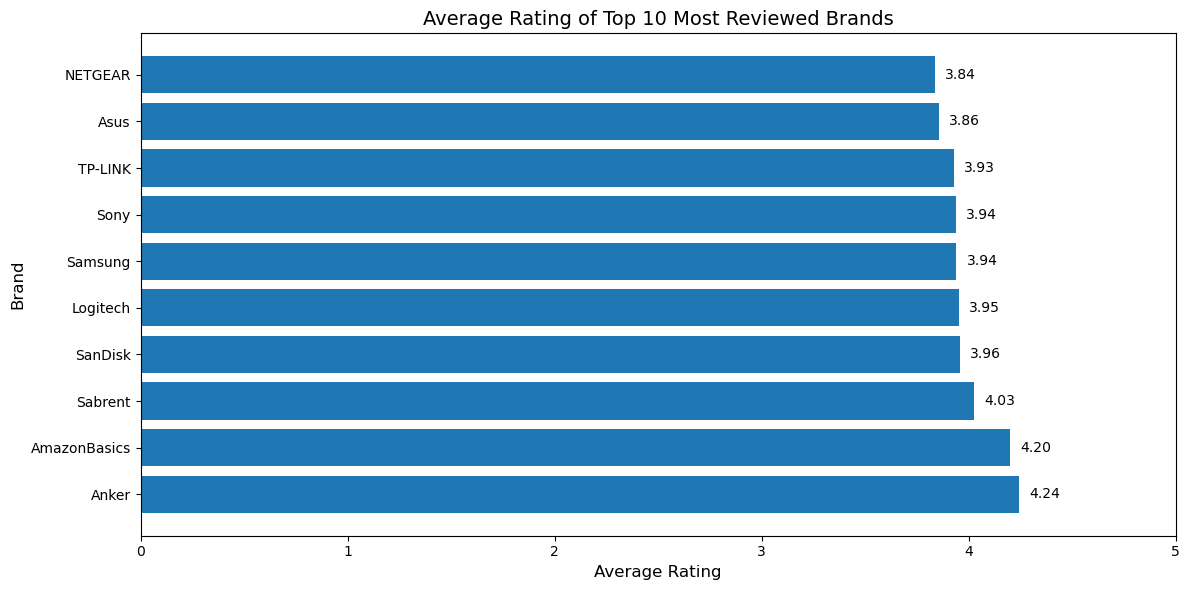

In [13]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(
    brand_stats['Brand'],
    brand_stats['Average Rating']
)

ax.set_xlabel('Average Rating', fontsize=12)
ax.set_ylabel('Brand', fontsize=12)
ax.set_title('Average Rating of Top 10 Most Reviewed Brands', fontsize=14)
ax.set_xlim(0, 5)

for bar, val in zip(bars, brand_stats['Average Rating']):
    ax.text(
        val + 0.05,
        bar.get_y() + bar.get_height()/2,
        f'{val:.2f}',
        va='center'
    )

plt.tight_layout()
plt.show()

# Aspect-Based Satisfaction Analysis: Warranty

## Objective

The goal of this section is to estimate customer satisfaction regarding the warranty aspect of products.

Instead of analyzing all reviews, we focus only on reviews that explicitly discuss warranty-related topics (e.g., warranty, guarantee, coverage, etc.). After identifying such reviews, we compute the average rating (overall) per product based only on those filtered reviews.

This provides an approximation of how satisfied customers are with the warranty of each product.

---

## Problem with Simple Keyword Matching

A naive approach would be to search only for exact words like:

- "warranty"
- "guarantee"

However, this approach is insufficient because:

1. Users may use synonyms (e.g., coverage, protection plan).
2. Users may make spelling mistakes (e.g., warrenty, garantee).
3. Contextual variations may exist.

---

## Proposed Solution

To improve coverage, we:

1. Use word embeddings (e.g., Word2Vec or pre-trained embeddings) to find words semantically similar to:
   - "warranty"
   - "guarantee"

2. Manually include common misspellings.

3. Create an extended keyword list including:
   - Original keywords
   - Similar words from embeddings
   - Common spelling mistakes

4. Filter reviews that contain at least one of these words.

5. Compute the average rating (`overall`) per product using only the filtered reviews.


### Step 1: Load Pretrained Word2Vec Model

In [14]:
word2vec_model = api.load('word2vec-google-news-300')

### Step 2: Find Similar Words

In [15]:
def get_similar_words(model, words, topn=20):
    similar_words = set()
    for word in words:
        try:
            similars = model.most_similar(word, topn=topn)
            for sim_word, score in similars:
                if score > 0.5:
                    similar_words.add(sim_word.lower())
        except KeyError:
            print(f"{word} Not Found")
    return similar_words

target_words = ['warranty', 'guarantee', 'Warranty', 'Guarantee']
similar_words = get_similar_words(word2vec_model, target_words)
misspellings = {
    'waranty', 'warenty', 'warrenty', 'warrantee', 'warrantie', 'warranties',
    'guarante', 'garantee', 'guarentee', 'gaurantee', 'guaranty', 'guarantees',
    'guarranty', 'warrranty'
}
all_warranty_words = similar_words.union(misspellings).union({'warranty', 'guarantee', 'warranties', 'guarantees'})

print(f"Number of keywords: {len(all_warranty_words)}")
print("Final keyword list:")
print(sorted(all_warranty_words))

Number of keywords: 58
Final keyword list:
['##-year/###', '#-year/##', '#-year/###_,###_mile', '1_owner_carfax', 'antec_quality', 'assurance', 'assurances', 'assure', 'auto_warranty', 'back_guarantee', 'corrosion_perforation', 'disclaimer_past_performance', 'eight-year/###_,###_mile', 'eligible_liabilities', 'ensure', 'ensured', 'extended_warranties', 'extended_warranty', 'five-year/###_,###_mile', 'garantee', 'gaurantee', 'guarante', 'guarantee', 'guarantee_nreg_scheme', 'guarantee_program', 'guarantee_programme', 'guaranteed', 'guaranteeing', 'guarantees', 'guaranty', 'guarentee', 'guarranty', 'gurantee', 'insure', 'lifetime_warranty', 'limited_lifetime_warranty', 'limited_powertrain_warranty', 'limited_warranty', 'manufacturer_warranty', 'match_guarantee', 'no_lapse_guarantee', 'pmp_mp4_players', 'powertrain_warranties', 'powertrain_warranty', 'price_guarantee', 'satisfaction_guarantee', 'three-year/###', 'valvoline_engine', 'waranty', 'warenty', 'warrantee', 'warrantees', 'warrant

### Step 3: Filter Reviews Containing Warranty-Related Words

In [16]:
def contains_warranty_words(text, warranty_words):
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    for word in warranty_words:
        if word.lower() in text_lower:
            return True
    return False

train_df['has_warranty_mention'] = train_df['reviewText'].apply(
    lambda x: contains_warranty_words(x, all_warranty_words)
)

warranty_reviews = train_df[train_df['has_warranty_mention']]

print(f"Number of all Reviews: {len(train_df):,}")
print(f"Number of warranty-related reviews: {len(warranty_reviews):,}")
print(f"Percentage of warranty-related reviews: {len(warranty_reviews)/len(train_df)*100:.2f}%")

Number of all Reviews: 838,944
Number of warranty-related reviews: 24,069
Percentage of warranty-related reviews: 2.87%


In [17]:
warranty_product_stats = (
    warranty_reviews
    .groupby("asin")["overall"]
    .mean()
    .reset_index()
    .rename(columns={"overall": "average_warranty_rating"})
)

# Sort descending
warranty_product_stats = warranty_product_stats.sort_values(
    "average_warranty_rating",
    ascending=False
)

warranty_product_stats.index = range(1, len(warranty_product_stats) + 1)

display(warranty_product_stats.head(10))

,asin,average_warranty_rating
1,B01HJ8E11E,5.0
2,B00O83BR7A,5.0
3,B00OBP9Q6E,5.0
4,B00OAJ5N6I,5.0
5,B01DDA7WXQ,5.0
6,B00O9RH38W,5.0
7,B00O9MF6ZY,5.0
8,B01DDGTWOM,5.0
9,B00O92TPM4,5.0
10,B00O8NVPBI,5.0


### Step 4: Compute Average Rating per Product

In [18]:
warranty_product_ratings = warranty_reviews.groupby('asin').agg({
    'overall': ['mean', 'count']
}).reset_index()
warranty_product_ratings.columns = ['asin', 'warranty_avg_rating', 'warranty_review_count']
warranty_product_ratings = warranty_product_ratings.merge(title_brand_df, on='asin', how='left')

# Only products with at least 5 warranty-related reviews
warranty_product_ratings = warranty_product_ratings[warranty_product_ratings['warranty_review_count'] >= 5]
warranty_product_ratings = warranty_product_ratings.sort_values('warranty_avg_rating', ascending=False)

result_df = warranty_product_ratings[
    ['brand', 'title', 'warranty_avg_rating', 'warranty_review_count']
].copy()
result_df.columns = [
    'Brand',
    'Product Title',
    'Average Warranty Rating',
    'Number of Warranty Reviews'
]
result_df.index = range(1, len(result_df) + 1)

print("Average Warranty Satisfaction Ratings (Products with ≥5 Warranty Reviews):\n")
display(result_df.head(20))

# Save results
result_df.to_csv('../outputs/warranty_satisfaction_ratings.csv', index=False)
print("Results saved to 'warranty_satisfaction_ratings.csv'.")

Average Warranty Satisfaction Ratings (Products with ≥5 Warranty Reviews):



,Brand,Product Title,Average Warranty Rating,Number of Warranty Reviews
1,Breakthrough Photography,82mm X2 UV Filter For Camera Lenses - UV Prote...,5.0,8
2,AUKEY,"AUKEY USB C to USB 3.0 Adapter, Mini USB Type ...",5.0,5
3,Blitzby,Blitzby Apple Watch Screen Protector 44mm (7 P...,5.0,5
4,Breakthrough Photography,Breakthrough Photography 82mm X4 3-Stop ND Fil...,5.0,5
5,Onkyo,Onkyo TX-RZ710 7.2-Channel Network A/V Receiver,5.0,5
6,Zakix,Zakix USB 2.0 Type A to Micro B USB Cable Pack...,5.0,5
7,Noctua,"Noctua NF-F12 PWM, 4-Pin Premium Quiet Fan (12...",5.0,10
8,ARCTIC,"ARCTIC MX-2 - Thermal Compound Paste, Carbon B...",5.0,6
9,Featured Brands 4,VideoSecu One Pair of Side Clamping Bookshelf ...,5.0,8
10,Noctua,"Noctua NF-A14 iPPC-3000 PWM, 4-Pin, Heavy Duty...",5.0,5


Results saved to 'warranty_satisfaction_ratings.csv'.


### Step 5: Overall Warranty Satisfaction Analysis

Average rating of warranty-related reviews: 3.44


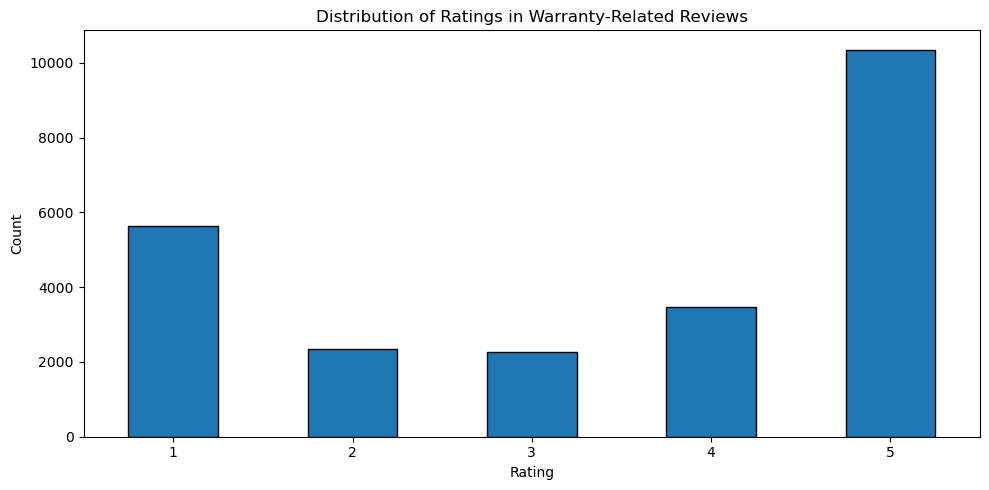

In [19]:
print(f"Average rating of warranty-related reviews: {warranty_reviews['overall'].mean():.2f}")

# Distribution of ratings for warranty-related reviews
plt.figure(figsize=(10, 5))

warranty_reviews['overall'].value_counts().sort_index().plot(kind='bar', edgecolor='black')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Warranty-Related Reviews')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Sentiment Analysis Model

## Objective

In this section, we aim to build a supervised sentiment analysis model that predicts a user's satisfaction score (from 1 to 5) based on the review text.

The target variable is:
- `overall` (integer rating from 1 to 5)

The main input feature is:
- `reviewText`

Optionally, additional features can be incorporated. However, the primary input is the review text.

---

## Problem Type

This is a multi-class classification problem with 5 classes:
- Class 1 → Very Negative
- Class 2 → Negative
- Class 3 → Neutral
- Class 4 → Positive
- Class 5 → Very Positive

---

## Model Choice

For this task, we use a **pre-trained Transformer model (BERT)** and fine-tune it on our dataset.

### Step 1: Preprocess

In [20]:
# text preprocess
def preprocess_text(text, summary=None):
    if pd.isna(text):
        text = ""
    else:
        text = str(text)

    # summary
    if summary and not pd.isna(summary):
        text = f"{summary}. {text}"

    # clean text
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

train_df['processed_text'] = train_df.apply(
    lambda row: preprocess_text(row['reviewText'], row['summary']), axis=1
)

train_df = train_df[train_df['processed_text'].str.len() > 10]
train_df['label'] = train_df['overall'] - 1

### Step 2: Sampling to reduce dataset size (for resource limitations)

In [21]:
SAMPLE_SIZE = 150000

if len(train_df) > SAMPLE_SIZE:
    # Stratified Sampling
    train_sample = train_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 5), random_state=42)
    )
else:
    train_sample = train_df

print(f"Number of selected samples: {len(train_sample):,}")
print("\nLabel distribution:")
print(train_sample['label'].value_counts().sort_index())

Number of selected samples: 150,000

Label distribution:
label
0    30000
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64


### Step 3: Train-validation split

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sample['processed_text'].values,
    train_sample['label'].values,
    test_size=0.15,
    random_state=42,
    stratify=train_sample['label'].values
)

print(f"Number of training samples: {len(X_train):,}")
print(f"Number of validation samples: {len(X_val):,}")

Number of training samples: 127,500
Number of validation samples: 22,500
